In [1]:

import torch
from torch import nn
from torch.optim import Adam
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from simulate import SimulationDataset  
import jax
from jax import jit, vmap, grad, random, value_and_grad
import jax.numpy as jnp


### Set device

In [2]:
seed = 0
# random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon)")
else:
    device = torch.device("cpu")
    print("Using CPU")



Using MPS (Apple Silicon)


### Define the parameters for the simulation

In [3]:
ns = 10000
sim = 'r2'
n = 4
dim = 2
nt = 1000
dt = 1e-3

### Generate the dataset and see the shape

In [4]:
import simulate
from simulate import SimulationDataset
simulation = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
simulation.simulate(ns)

In [5]:
simulation.data.shape

(10000, 500, 4, 6)

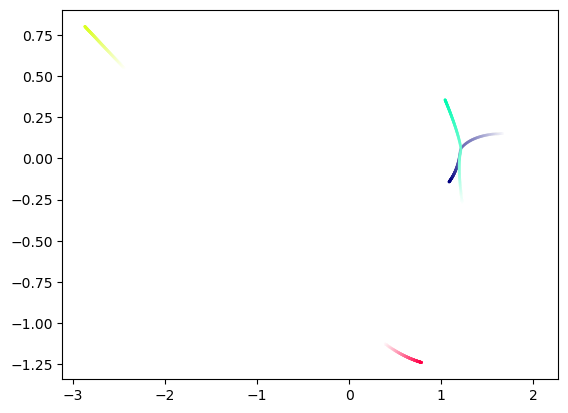

In [5]:
simulation.plot(0, animate=True, plot_size=False)

### Split the data and put into dataloader

In [6]:
accel_data = simulation.get_acceleration()

# Convert simulation and acceleration data directly to tensors
X = torch.tensor(np.array(simulation.data), dtype=torch.float32)  # Shape: (num_samples, num_time_steps, num_particles, num_features)
Y = torch.tensor(np.array(accel_data), dtype=torch.float32)       # Shape: (num_samples, num_time_steps, num_particles, output_dim)

# Select every 5th timestep along time dimension
X = X[:, ::5].reshape(-1, X.shape[2], X.shape[3])  # Flatten sample & time dims
Y = Y[:, ::5].reshape(-1, Y.shape[2], Y.shape[3])  # Flatten sample & time dims

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, shuffle=False)

In [7]:
print(X_train.shape,X_test.shape, Y_train.shape, Y_test.shape)

torch.Size([750000, 4, 6]) torch.Size([250000, 4, 6]) torch.Size([750000, 4, 2]) torch.Size([250000, 4, 2])


In [8]:
from models import NbodyGNN,get_edge_index

edge_index = get_edge_index(n, sim)


from torch_geometric.data import Data, DataLoader

train_data_list = [
    Data(
        x=X_train[i],  
        edge_index=edge_index,  
        y=Y_train[i]
    ) for i in range(len(Y_train))
]

test_indices = np.random.choice(len(X_test), size=1024, replace=False)  # Randomly select 1024 indices from the test set
test_data_list = [
    Data(
        x=X_test[i],  
        edge_index=edge_index,  
        y=Y_test[i]
    ) for i in test_indices
]



batch = 64

trainloader = DataLoader(train_data_list, batch_size=batch, shuffle=True)
testloader = DataLoader(test_data_list, batch_size=1024, shuffle=False)


/Users/liuyihao/Desktop/yl2063/src/models.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_e3pikzc5fh/croot/libtorch_1738337599132/work/torch/csrc/utils/tensor_new.cpp:281.)
  edge_index = torch.tensor([row, col], dtype=torch.long)
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Standard model

In [9]:
aggr = 'add'
hidden = 300
msg_dim = 100
n_f = simulation.data.shape[3]

In [10]:
from torch.optim.lr_scheduler import OneCycleLR
initial_learing_rate = 1e-3


total_epochs = 30


batch_per_epoch = len(trainloader)


batch_per_epoch

11719

In [12]:

model_standard = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_standard = torch.optim.Adam(model_standard.parameters(), lr=initial_learing_rate, weight_decay=1e-8)


sched_standard = OneCycleLR(opt_standard, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [13]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-r2-standard", reinit=True)

for epoch in range(total_epochs):
    model_standard.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_standard.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_standard.loss(batch)
        loss.backward()
        opt_standard.step()
        sched_standard.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 150.421907
Epoch 2/30, Loss: 134.310830
Epoch 3/30, Loss: 134.064397
Epoch 4/30, Loss: 125.767456
Epoch 5/30, Loss: 118.202656
Epoch 6/30, Loss: 112.680784
Epoch 7/30, Loss: 109.167743
Epoch 8/30, Loss: 107.962774
Epoch 9/30, Loss: 104.728592
Epoch 10/30, Loss: 103.772654
Epoch 11/30, Loss: 102.081615
Epoch 12/30, Loss: 98.753548
Epoch 13/30, Loss: 95.819060
Epoch 14/30, Loss: 94.000784
Epoch 15/30, Loss: 90.926870
Epoch 16/30, Loss: 89.344638
Epoch 17/30, Loss: 85.838217
Epoch 18/30, Loss: 83.057849
Epoch 19/30, Loss: 79.182513
Epoch 20/30, Loss: 75.080114
Epoch 21/30, Loss: 69.661483
Epoch 22/30, Loss: 65.032015
Epoch 23/30, Loss: 59.172272
Epoch 24/30, Loss: 53.039009
Epoch 25/30, Loss: 44.925533
Epoch 26/30, Loss: 39.130972
Epoch 27/30, Loss: 31.857048
Epoch 28/30, Loss: 26.278983
Epoch 29/30, Loss: 22.239869
Epoch 30/30, Loss: 20.253466


In [14]:
# Save the model state
import os

root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r2_standard.pth")

torch.save(model_standard.state_dict(), save_path)

In [11]:
import os
model_standard = NbodyGNN(n_f, msg_dim, dim,  hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r2_standard.pth")
state_dict = torch.load(save_path, map_location=device)
model_standard.load_state_dict(state_dict)


model_standard.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_67482/681601954.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locatio

NbodyGNN()

In [15]:
model_standard.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_standard(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 8.944685


Selected channels: ['msg76', 'msg70']


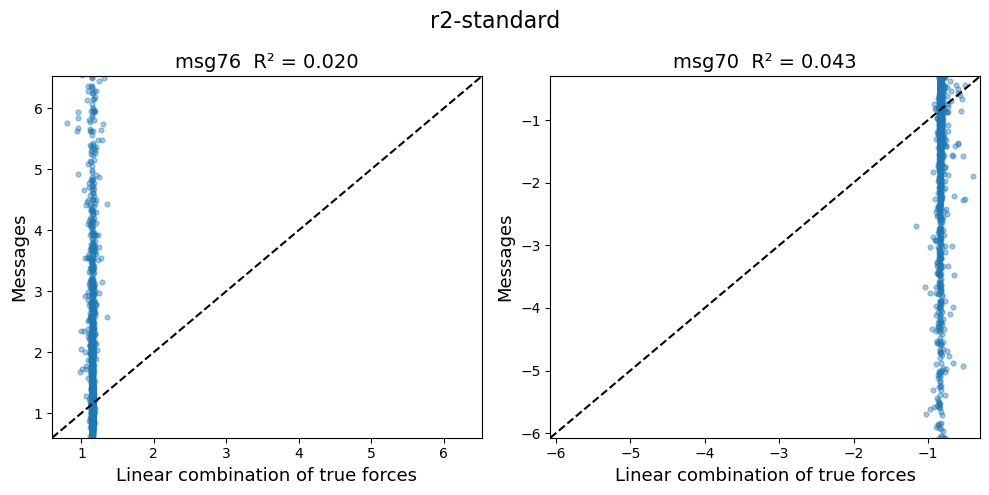

In [14]:

from message_processing import measure_latent, fit_multioutput_force
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
# Measure latent variables
latent_df_standard = measure_latent(model_standard, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_standard['fx_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dx'] / (latent_df_standard['r'] ** 3 + 1e-6))
latent_df_standard['fy_true'] = (latent_df_standard['m1'] * latent_df_standard['m2']) * \
                    (latent_df_standard['dy'] / (latent_df_standard['r'] ** 3 + 1e-6))

# Fit multi-output linear regression to find top channels
lr, top_channels= fit_multioutput_force(latent_df_standard, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_standard[['fx_true','fy_true']].values

# True messages
Messages = latent_df_standard[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r2-standard", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
import pysr
sr_standard= pysr.PySRRegressor(
  niterations=100,
  binary_operators=["+", "-", "*", "/"],
  unary_operators=["cube"],
  run_id="r2-standard",
  random_state=seed,
  parallelism="serial",
)
df_sub_standard = latent_df_standard[['dx','dy','r','m1','m2', top_channels[0]]].sample(5000)
X = df_sub_standard[['dx','dy','r','m1','m2']].values
Y = df_sub_standard[top_channels[0]].values
sr_standard.fit(X, Y)
print(sr_standard)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.040e+05
Progress: 1208 / 2480 total iterations (48.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.465e-01  1.594e+01  y = 0.39366
5           5.262e-01  9.455e-03  y = -0.68838 / (-0.55404 - x₂)
7           4.481e-01  8.034e-02  y = (x₁ * 0.29495) / (x₂ * x₂)
9           2.932e-01  2.121e-01  y = ((x₁ / (x₂ * x₂)) + 1.3341) * 0.29497
11          1.698e-01  2.731e-01  y = (((x₁ * (x₄ * 0.13156)) / x₂) / x₂) - -0.39494
13          1.561e-01  4.227e-02  y = ((x₁ / x₂) * (((x₄ + 0.86607) / x₂) * 0.10825)) - -0.3...
                                      9469
15          1.248e-01  1.118e-01  y = ((((x₁ * x₄) / (x₂ + (x₁ * -0.49733))) / x₂) * 0.11737...
                                      ) + 0.32737
17          1.116e-01  5.607e-02  y = ((

### Bottleneck model

In [17]:

msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_bottleneck = OneCycleLR(opt_bottleneck, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)


In [18]:
import wandb
wandb.init(project="DIS-final-pro", name="Train-r2-bottleneck", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,20.25347


Epoch 1/30, Loss: 156.036852
Epoch 2/30, Loss: 138.263193
Epoch 3/30, Loss: 131.367147
Epoch 4/30, Loss: 125.878477
Epoch 5/30, Loss: 118.173420
Epoch 6/30, Loss: 111.009056
Epoch 7/30, Loss: 105.745676
Epoch 8/30, Loss: 106.128632
Epoch 9/30, Loss: 103.622890
Epoch 10/30, Loss: 100.184359
Epoch 11/30, Loss: 98.718756
Epoch 12/30, Loss: 97.891454
Epoch 13/30, Loss: 92.057996
Epoch 14/30, Loss: 92.441678
Epoch 15/30, Loss: 88.711637
Epoch 16/30, Loss: 87.064774
Epoch 17/30, Loss: 84.825507
Epoch 18/30, Loss: 80.898924
Epoch 19/30, Loss: 78.189080
Epoch 20/30, Loss: 73.727426
Epoch 21/30, Loss: 68.921862
Epoch 22/30, Loss: 63.592810
Epoch 23/30, Loss: 58.475439
Epoch 24/30, Loss: 54.004274
Epoch 25/30, Loss: 45.573404
Epoch 26/30, Loss: 38.607154
Epoch 27/30, Loss: 32.314269
Epoch 28/30, Loss: 26.533714
Epoch 29/30, Loss: 23.066285
Epoch 30/30, Loss: 21.452956


In [19]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r2_bottleneck.pth")

torch.save(model_bottleneck.state_dict(), save_path)

In [18]:
import os
model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim,  hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r2_bottleneck.pth")
state_dict = torch.load(save_path, map_location=device)
model_bottleneck.load_state_dict(state_dict)


model_bottleneck.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_67482/28209884.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_location

NbodyGNN()

In [20]:
model_bottleneck.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_bottleneck(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 9.267734


Selected channels: ['msg1', 'msg0']


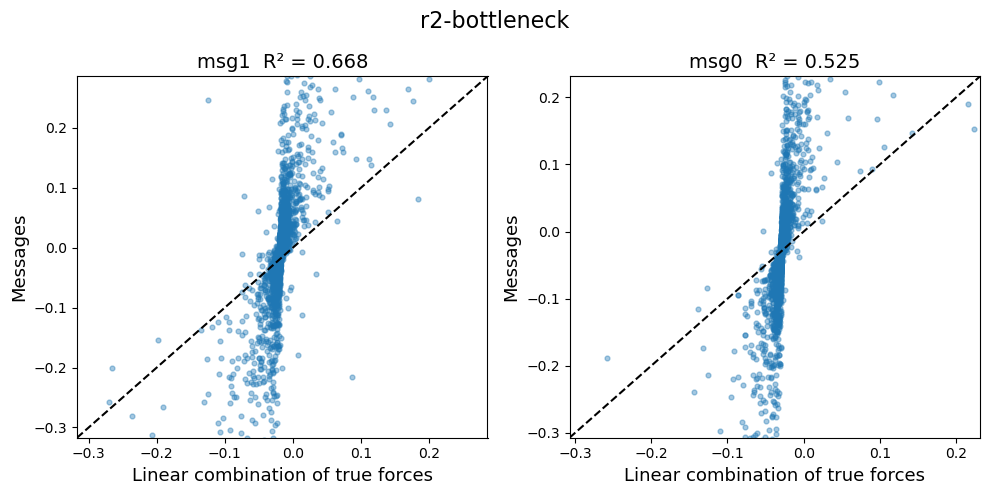

In [21]:
from message_processing import measure_latent, fit_multioutput_force
from sklearn.metrics import r2_score


# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)



# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 3 + 1e-6))
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 3 + 1e-6))


# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r2-bottleneck", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [22]:
import pysr
sr_bottleneck = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"],
    run_id="r2-bottleneck",
    random_state=seed,
    parallelism="serial",
)
df_sub_bottleneck = latent_df_bottleneck[['dx', 'dy', 'r', 'm1','m2', top_channels[0]]].sample(5000)
X = df_sub_bottleneck[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_bottleneck[top_channels[0]].values
sr_bottleneck.fit(X, Y)
print(sr_bottleneck)



/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.190e+04
Progress: 329 / 3100 total iterations (10.613%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.840e+00  1.594e+01  y = -0.030202
3           2.658e+00  3.314e-02  y = -0.080715 / x₂
4           2.447e+00  8.256e-02  y = cube(-0.020501 / x₂)
5           1.900e+00  2.533e-01  y = (x₄ / x₂) * -0.027711
6           1.351e+00  3.409e-01  y = (x₀ / cube(x₂)) * 0.0028175
11          1.126e+00  3.645e-02  y = ((0.0008153 / x₁) * ((x₄ + -0.71859) / x₂)) * 0.2799
12          6.422e-01  5.614e-01  y = x₄ * (x₀ * cube((1.1577 / (x₂ / 0.071664)) - -0.19812)...
                                      )
16          3.216e-01  1.729e-01  y = (-0.60276 / x₀) * ((x₀ * (x₀ * (-0.12566 / (cube(x₂) /...
                                       x₂)))) * x₄)
19

[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 7.220e+04
Progress: 1032 / 3100 total iterations (33.290%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.840e+00  1.594e+01  y = -0.030202
3           2.658e+00  3.314e-02  y = -0.080715 / x₂
4           2.446e+00  8.297e-02  y = -9.0767e-06 / cube(x₂)
5           1.900e+00  2.529e-01  y = (x₄ / x₂) * -0.027711
6           1.351e+00  3.409e-01  y = (x₀ * 0.0028175) / cube(x₂)
7           1.191e+00  1.259e-01  y = ((x₀ / x₂) / x₂) * 0.31058
8           6.748e-01  5.681e-01  y = (x₄ * (x₀ * 0.00063213)) / cube(x₂)
9           3.216e-01  7.412e-01  y = (x₄ * ((0.075743 / x₂) / x₂)) * x₀
11          1.435e-01  4.033e-01  y = x₀ * ((x₄ + 2.0889) * ((0.060808 / x₂) / x₂))
12          1.435e-01  5.960e-08  y = ((((-2.0891 - x₄) * x₀) * x₂) / cube(x₂)

In [16]:
sr2_bottleneck = pysr.PySRRegressor(
    niterations=80,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"]
)
df_sub_bottleneck2 = latent_df_bottleneck[['dx', 'dy', 'r', 'm1','m2', top_channels[1]]].sample(5000)
X = df_sub_bottleneck2[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_bottleneck2[top_channels[1]].values
sr2_bottleneck.fit(X, Y)
print(sr2_bottleneck)


/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:



Expressions evaluated per second: 2.630e+05
Progress: 1348 / 2480 total iterations (54.355%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.754e-01  1.594e+01  y = -0.031241
3           2.709e-01  8.197e-03  y = -0.0047968 / x₂
5           2.207e-01  1.025e-01  y = -0.0014985 / (x₂ - 0.041887)
7           2.044e-01  3.839e-02  y = (x₁ / (x₂ - 0.017922)) * -0.057932
8           1.332e-01  4.282e-01  y = (x₁ * -0.020729) / cube(x₂ - -0.013718)
10          4.990e-02  4.910e-01  y = (x₄ / cube((x₂ / -0.23554) + -0.060353)) * x₁
12          1.999e-02  4.574e-01  y = ((x₀ + (x₁ * x₄)) * -0.011252) / cube(x₂ - -0.012282)
14          1.928e-02  1.816e-02  y = ((((x₄ * x₁) + x₀) / cube(x₂ - -0.012727)) * -0.011763...
                                      ) + -0.025028
18          1.911e

In [ ]:
# import pandas as pd
# from sklearn.linear_model import LinearRegression
# def fit_each_channel_by_force_dim(latent_df, dim):
#     """
#     对 top-D 个消息通道，分别用 fx_true 和 fy_true 做单变量线性回归。

#     Parameters:
#         latent_df (pd.DataFrame): 必须包含列 'fx_true','fy_true' 和 'msg0','msg1',...
#         dim (int):           要选出的通道数量（一般等于空间维度）

#     Returns:
#         top_channels (list[str]):
#             被选出的 dim 个消息通道名
#         models (dict):
#             models[ch]['fx'] = 针对 fx_true 的 LinearRegression
#             models[ch]['fy'] = 针对 fy_true 的 LinearRegression
#         r2_scores (dict):
#             r2_scores[ch]['fx'] = 模型在 fx_true 回归上的 R²
#             r2_scores[ch]['fy'] = 模型在 fy_true 回归上的 R²
#     """
#     # 1) 按方差挑 top-D 个 msg 列
#     msg_cols = [c for c in latent_df.columns if c.startswith("msg")]
#     stds = latent_df[msg_cols].std()
#     top_channels = stds.nlargest(dim).index.tolist()

#     models = {}
#     r2_scores = {}

#     # 2) 对每个通道，分别只用 fx_true 和 fy_true 回归
#     for ch in top_channels:
#         y = latent_df[ch].values            # shape (N_edges,)

#         models[ch] = {}
#         r2_scores[ch] = {}

#         # —— 用 fx_true 回归 —— 
#         X_fx = latent_df[["fx_true"]].values   # shape (N_edges,1)
#         lr_fx = LinearRegression().fit(X_fx, y)
#         models[ch]['fx'] = lr_fx
#         r2_scores[ch]['fx'] = lr_fx.score(X_fx, y)

#         # —— 用 fy_true 回归 —— 
#         X_fy = latent_df[["fy_true"]].values   # shape (N_edges,1)
#         lr_fy = LinearRegression().fit(X_fy, y)
#         models[ch]['fy'] = lr_fy
#         r2_scores[ch]['fy'] = lr_fy.score(X_fy, y)

#     return top_channels, models, r2_scores
# top_ch, models, r2s = fit_each_channel_by_force_dim(latent_df_bottleneck, dim=2)
# print("Selected channels:", top_ch)
# for ch in top_ch:
#     print(f"{ch}:")
#     print(f"  R²_fx = {r2s[ch]['fx']:.4f}")
#     print(f"  R²_fy = {r2s[ch]['fy']:.4f}")




Selected channels: ['msg1', 'msg0']
msg1:
  R²_fx = 0.3299
  R²_fy = 0.0812
msg0:
  R²_fx = 0.0840
  R²_fy = 0.3002


### L1 regularization model

In [32]:
model_l1 = NbodyGNN(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)

opt_l1 = torch.optim.Adam(model_l1.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_l1 = OneCycleLR(opt_l1, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [33]:
wandb.init(project="DIS-final-pro", name="Train-r2-l1", reinit=True)
for epoch in range(total_epochs):
    model_l1.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_l1.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_l1.loss(batch)
        loss.backward()
        opt_l1.step()
        sched_l1.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,21.45296


Epoch 1/30, Loss: 168.726311
Epoch 2/30, Loss: 137.080903
Epoch 3/30, Loss: 130.826087
Epoch 4/30, Loss: 128.473741
Epoch 5/30, Loss: 123.995617
Epoch 6/30, Loss: 120.765638
Epoch 7/30, Loss: 117.828684
Epoch 8/30, Loss: 114.695619
Epoch 9/30, Loss: 113.189351
Epoch 10/30, Loss: 109.013936
Epoch 11/30, Loss: 107.775382
Epoch 12/30, Loss: 103.961738
Epoch 13/30, Loss: 101.944124
Epoch 14/30, Loss: 99.505056
Epoch 15/30, Loss: 96.483313
Epoch 16/30, Loss: 95.474075
Epoch 17/30, Loss: 91.559934
Epoch 18/30, Loss: 87.790729
Epoch 19/30, Loss: 87.331130
Epoch 20/30, Loss: 81.839382
Epoch 21/30, Loss: 76.608401
Epoch 22/30, Loss: 70.829946
Epoch 23/30, Loss: 64.275799
Epoch 24/30, Loss: 57.925368
Epoch 25/30, Loss: 50.643547
Epoch 26/30, Loss: 41.993190
Epoch 27/30, Loss: 35.975784
Epoch 28/30, Loss: 28.852107
Epoch 29/30, Loss: 24.098018
Epoch 30/30, Loss: 22.263256


In [34]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r2_l1.pth")

torch.save(model_l1.state_dict(), save_path)

In [23]:
import os
model_l1 = NbodyGNN(n_f, msg_dim, dim,  hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0.02).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r2_l1.pth")
state_dict = torch.load(save_path, map_location=device)
model_l1.load_state_dict(state_dict)


model_l1.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_67482/894663696.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locatio

NbodyGNN()

In [36]:
model_l1.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_l1(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 8.229642


Selected channels: ['msg75', 'msg5']


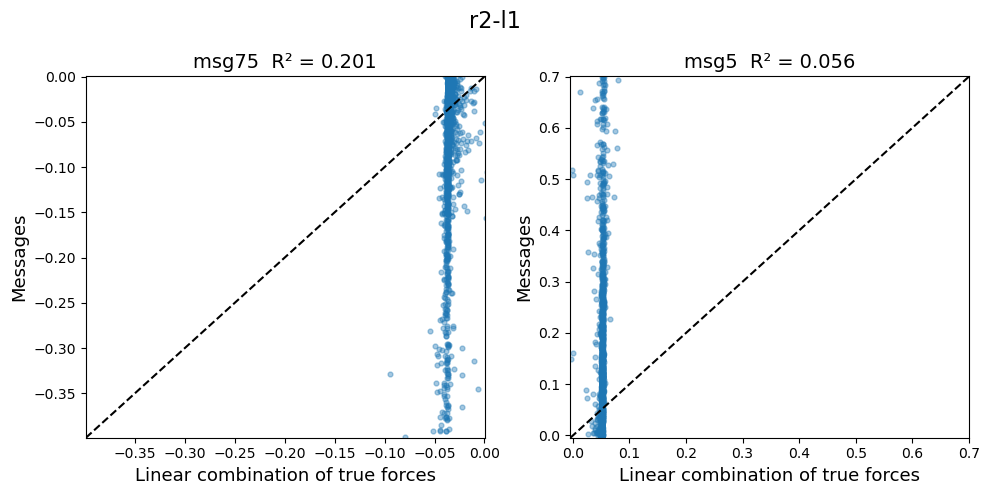

In [25]:
# Measure latent variables
latent_df_l1 = measure_latent(model_l1, testloader, device=device, dim=dim, msg_dim=msg_dim)

# compute true force components and add them to latent_df
latent_df_l1['fx_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dx'] / (latent_df_l1['r'] ** 3 + 1e-6))
latent_df_l1['fy_true'] = (latent_df_l1['m1'] * latent_df_l1['m2']) * \
                    (latent_df_l1['dy'] / (latent_df_l1['r'] ** 3 + 1e-6))

# 
# low_fx, high_fx = np.percentile(latent_df_l1['fx_true'], [1,99])
# low_fy, high_fy = np.percentile(latent_df_l1['fy_true'], [1,99])
# mask = (
#     (latent_df_l1['fx_true'] >= low_fx) & (latent_df_l1['fx_true'] <= high_fx)
#   & (latent_df_l1['fy_true'] >= low_fy) & (latent_df_l1['fy_true'] <= high_fy)
# )
# df_filtered_l1 = latent_df_l1[mask].copy()
#

# df_filtered_l1 = latent_df_l1.copy()

# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_l1, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_l1[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_l1[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("r2-l1", fontsize=16)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()


In [26]:
import pysr
sr_l1 = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"],
    run_id="r2-l1",
    random_state=seed,
    parallelism="serial",
)
df_sub_l1 = latent_df_l1[['dx', 'dy', 'r', 'm1','m2',top_channels[0]]].sample(5000)
X = df_sub_l1[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_l1[top_channels[0]].values
sr_l1.fit(X, Y)
print(sr_l1)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.130e+04
Progress: 368 / 3100 total iterations (11.871%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.128e-02  1.594e+01  y = -0.035686
3           6.508e-02  4.554e-02  y = -0.014455 / x₂
5           5.155e-02  1.165e-01  y = (x₄ * -0.0085544) / x₂
7           4.056e-02  1.199e-01  y = (-0.020168 / (x₂ + 0.010461)) * x₄
8           2.997e-02  3.025e-01  y = cube(-0.27721 / (x₂ + 0.32276)) * x₄
10          2.945e-02  8.789e-03  y = (x₄ * -0.12943) / (0.31257 - cube(x₂ * -3.5915))
12          2.919e-02  4.442e-03  y = (x₄ * -0.28485) / (0.55128 - cube((x₂ + 0.092098) * -3...
                                      .5561))
14          2.736e-02  3.228e-02  y = (x₄ * -0.17152) / ((0.49479 + x₀) - cube((x₂ * -3.9414...
                            

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.128e-02  1.594e+01  y = -0.035686
3           6.508e-02  4.554e-02  y = -0.014455 / x₂
5           5.155e-02  1.165e-01  y = (x₄ * -0.0085544) / x₂
7           3.530e-02  1.894e-01  y = (x₄ / (x₂ - -0.035688)) * -0.029071
8           2.997e-02  1.637e-01  y = cube(-0.27721 / (x₂ + 0.32276)) * x₄
10          2.920e-02  1.296e-02  y = cube(-0.27721 / (x₂ + 0.32276)) * (x₄ - x₀)
11          2.475e-02  1.653e-01  y = x₄ * (-0.012025 / (x₂ - ((x₀ / -1.3223) + -0.010406)))
12          2.398e-02  3.159e-02  y = (x₄ / cube(x₂ - ((x₀ / -1.4873) + -0.22297))) * -0.006...
                                      6051
13          1.881e-02  2.431e-01  y = (((x₄ / (x₂ - -0.02135)) * -0.019111) * (x₂ - x₀)) / x...
                                      ₂
14          1.871e-02  4.922e-03  y = (x₄ * ((-0.019909 / cube(x₂ - -0.36369)) * (x₂ - x₀)))...


### KL divergence model

In [29]:
from models import VariationNbody

In [11]:
model_kl = VariationNbody(n_f, msg_dim, dim, hidden=hidden, edge_index=get_edge_index(n, sim), beta=1.0).to(device)

opt_kl = torch.optim.Adam(model_kl.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

sched_kl = OneCycleLR(opt_kl, max_lr=initial_learing_rate,
                   steps_per_epoch=batch_per_epoch,
                   epochs=total_epochs, final_div_factor=1e5)

In [12]:
import wandb
wandb.init(project="DIS-final-pro-kl", name="Train-r2", reinit=True)
for epoch in range(total_epochs):
    model_kl.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_kl.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_kl.loss(batch)
        loss.backward()
        opt_kl.step()
        sched_kl.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(
wandb: Currently logged in as: liuyihao649 (liuyihao649-university-of-cambridge) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/30, Loss: 21.920900
Epoch 2/30, Loss: 21.872075
Epoch 3/30, Loss: 20.179238
Epoch 4/30, Loss: 19.095706
Epoch 5/30, Loss: 18.903415
Epoch 6/30, Loss: 18.636964
Epoch 7/30, Loss: 17.970676
Epoch 8/30, Loss: 17.729756
Epoch 9/30, Loss: 17.313528
Epoch 10/30, Loss: 16.998159
Epoch 11/30, Loss: 16.768391
Epoch 12/30, Loss: 16.683772
Epoch 13/30, Loss: 16.356674
Epoch 14/30, Loss: 16.341703
Epoch 15/30, Loss: 15.766257
Epoch 16/30, Loss: 15.338588
Epoch 17/30, Loss: 14.872037
Epoch 18/30, Loss: 14.595374
Epoch 19/30, Loss: 14.076576
Epoch 20/30, Loss: 13.425816
Epoch 21/30, Loss: 12.855760
Epoch 22/30, Loss: 12.047462
Epoch 23/30, Loss: 11.560018
Epoch 24/30, Loss: 10.869203
Epoch 25/30, Loss: 10.031060
Epoch 26/30, Loss: 9.142891
Epoch 27/30, Loss: 8.383470
Epoch 28/30, Loss: 7.613648
Epoch 29/30, Loss: 7.179911
Epoch 30/30, Loss: 6.964405


In [13]:
import os


root_checkpoints = os.path.join("..", "model_weights")


os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r2_kl.pth")

torch.save(model_kl.state_dict(), save_path)

In [32]:
import os
model_kl = VariationNbody(n_f, msg_dim, dim,  hidden=hidden, edge_index=get_edge_index(n, sim), beta=1).to(device)
root_checkpoints = os.path.join("..", "model_weights")
os.makedirs(root_checkpoints, exist_ok=True)

save_path = os.path.join(root_checkpoints, "r2_kl.pth")
state_dict = torch.load(save_path, map_location=device)
model_kl.load_state_dict(state_dict)


model_kl.eval()

/var/folders/t1/80vwgky503qdx678h0vqjcmw0000gn/T/ipykernel_67482/844303313.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(save_path, map_locatio

VariationNbody()

In [14]:
model_kl.eval()  
total_loss = 0.0
num_batches = 0

with torch.no_grad():  
    for batch in testloader:
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        y_pred = model_kl(batch.x,batch.edge_index)  # Predict acceleration
        loss = torch.nn.functional.l1_loss(y_pred, batch.y)  # Loss
        
        total_loss += loss.item()
        num_batches += 1

average_loss = total_loss / num_batches  # Average loss
print(f"Test Loss: {average_loss:.6f}")

Test Loss: 12.415461


Top μ channels: ['mu67', 'mu91']
Multi-output μ‐linear fit R² = 0.1623


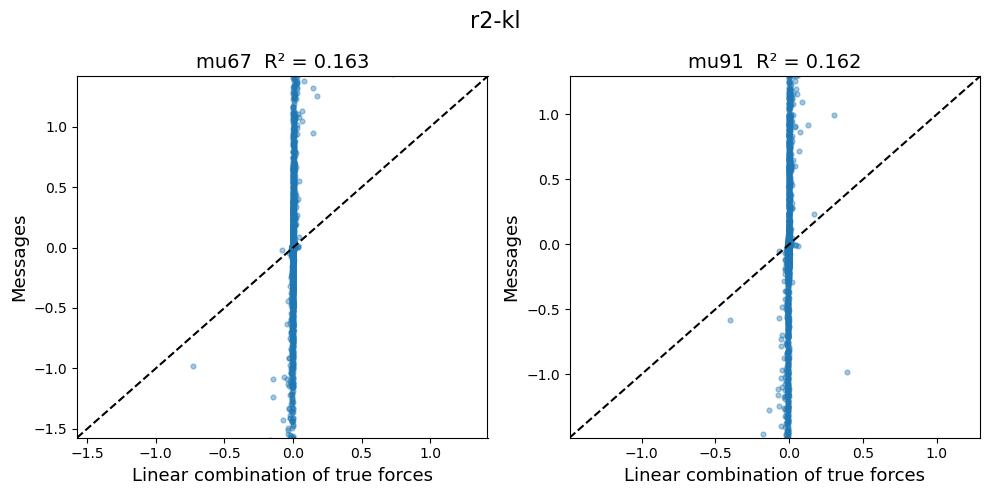

In [34]:
from message_processing import measure_variational_latent
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score   

df = measure_variational_latent(
    model_kl, testloader, device=device,
    dim=dim, msg_dim=msg_dim
)

# Select dim dimensions with largest variance
mu_cols = [c for c in df.columns if c.startswith("mu")]
top_mu  = df[mu_cols].std().nlargest(dim).index.tolist()
print("Top μ channels:", top_mu)

# Compute true force components
df['fx_true'] = (df['m1'] * df['m2']) * (df['dx'] / (df['r'] ** 3 + 1e-6))
df['fy_true'] = (df['m1'] * df['m2']) * (df['dy'] / (df['r'] ** 3 + 1e-6))


Xs = df[['fx_true','fy_true']].values       # (N,2)
Ysm   = df[top_mu].values                     # (N,dim)

# fit 
lr_mu = LinearRegression().fit(Xs, Ysm)
r2_mu = lr_mu.score(Xs, Ysm)
print(f"Multi-output μ‐linear fit R² = {r2_mu:.4f}")
# Predicted message value using the linear regression model from the force
Predicted_messages = lr_mu.predict(Xs)

fig, axes = plt.subplots(1, dim, figsize=(10, 5))
fig.suptitle("r2-kl", fontsize=16)

for idx, ch in enumerate(top_mu):
    y_true_ch = Ysm[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    ax = axes[idx]
    ax.scatter(y_pred_ch, y_true_ch, s=12, alpha=0.4)
    ax.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    ax.set_xlim(p_lower, p_upper)
    ax.set_ylim(p_lower, p_upper)
    ax.set_xlabel("Linear combination of true forces", fontsize=13)
    ax.set_ylabel("Messages", fontsize=13)
    single_r2 = r2_score(y_true_ch, y_pred_ch)
    ax.set_title(f"{ch}  R² = {single_r2:.3f}", fontsize=14)

plt.tight_layout()
plt.show()

In [36]:

import pysr
sr_kl = pysr.PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["cube"],
    run_id="r2-kl",
    random_state=seed,
    parallelism="serial",
)
df_sub_kl = df[['dx', 'dy', 'r', 'm1','m2',top_mu[0]]].sample(5000)
X = df_sub_kl[['dx', 'dy', 'r','m1','m2']].values
Y = df_sub_kl[top_mu[0]].values
sr_kl.fit(X, Y)
print(sr_kl)

/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:2776: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/opt/anaconda3/envs/symbolic_distillation/lib/python3.12/site-packages/pysr/sr.py:1850: UserWarning: Note: Setting `random_state` without also setting `deterministic=True` and `parallelism='serial'` will result in non-deterministic searches.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.510e+04
Progress: 375 / 3100 total iterations (12.097%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.300e-01  1.594e+01  y = 0.001401
3           7.279e-01  1.426e-03  y = x₃ * -0.017287
4           7.266e-01  1.788e-03  y = cube(-0.008712 / x₂)
5           6.896e-01  5.226e-02  y = x₀ * (-0.28764 / x₂)
7           4.610e-01  2.014e-01  y = ((x₀ / x₂) * -0.1331) / x₂
9           2.820e-01  2.456e-01  y = ((-0.45095 / (x₂ + 0.030101)) * x₀) / x₂
10          2.766e-01  1.943e-02  y = (cube(-0.65989 / (x₂ + 0.027413)) * x₀) * 0.21366
12          2.281e-01  9.646e-02  y = ((-0.45947 / cube(x₂ + 0.28229)) * x₀) / (x₂ / 0.55737...
                                      )
14          2.281e-01  4.113e-06  y = (((-0.45947 / cube(0.28229 + x₂)) * x₀)

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.300e-01  1.594e+01  y = 0.0013897
3           7.279e-01  1.426e-03  y = x₃ * -0.017287
4           7.266e-01  1.849e-03  y = -7.4518e-07 / cube(x₂)
5           6.896e-01  5.220e-02  y = x₀ * (-0.28759 / x₂)
6           6.630e-01  3.934e-02  y = x₀ * (-0.00057309 / cube(x₂))
7           4.610e-01  3.635e-01  y = ((x₀ * -0.1331) / x₂) / x₂
8           2.270e-01  7.083e-01  y = (x₀ / cube(x₂ + 0.046788)) * -0.14888
10          2.263e-01  1.585e-03  y = ((x₀ * -0.14887) - 0.00010556) / cube(x₂ + 0.046807)
12          1.617e-01  1.679e-01  y = cube(-0.54864 / (x₂ + 0.05255)) * ((x₁ * 0.41976) + x₀...
                                      )
14          1.615e-01  6.361e-04  y = cube(-0.81268 / (x₂ + (x₂ + 0.10227))) * (x₁ + (x₀ / 0...
                                      .42632))
16          1.436e-01  5.899e-02  y = ((x₁ * 0.44994) + x

In [30]:
msg_dim_bottleneck=2

model_bottleneck = NbodyGNN(n_f, msg_dim_bottleneck, dim, dt=0.1, hidden=hidden, edge_index=get_edge_index(n, sim), aggr=aggr,l1_reg_weight=0).to(device)

opt_bottleneck = torch.optim.Adam(model_bottleneck.parameters(), lr=initial_learing_rate, weight_decay=1e-8)

final_lr = initial_learing_rate / 1e5


from torch.optim.lr_scheduler import CosineAnnealingLR
total_epochs = 80
sched_bottleneck_2layer_80_cos = CosineAnnealingLR(
    optimizer=opt_bottleneck,
    T_max=total_epochs * batch_per_epoch,
    eta_min=final_lr
)


In [31]:
import wandb
wandb.init(project="DIS-final-project", name="Train-r2-bottleneck-2layer-cos-80", reinit=True)
for epoch in range(total_epochs):
    model_bottleneck.train()
    total_loss = 0
    num_batches = 0

    for batch in trainloader:
        opt_bottleneck.zero_grad()
        batch.x = batch.x.to(device)
        batch.y = batch.y.to(device)
        batch.edge_index = batch.edge_index.to(device)

        loss = model_bottleneck.loss(batch)
        loss.backward()
        opt_bottleneck.step()
        sched_bottleneck_2layer_80_cos.step()

        total_loss += loss.item()
        num_batches += 1

    average_loss = total_loss / num_batches
    print(f"Epoch {epoch+1}/{total_epochs}, Loss: {average_loss:.6f}")
    # Log to wandb
    wandb.log({"train_loss": average_loss, "epoch": epoch + 1})

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▇▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▁▁▁
epoch,30
train_loss,21.18288


Epoch 1/80, Loss: 123.732251
Epoch 2/80, Loss: 107.349083
Epoch 3/80, Loss: 104.302675
Epoch 4/80, Loss: 102.697318
Epoch 5/80, Loss: 99.712162
Epoch 6/80, Loss: 96.792333
Epoch 7/80, Loss: 95.197490
Epoch 8/80, Loss: 93.576634
Epoch 9/80, Loss: 91.509219
Epoch 10/80, Loss: 90.731196
Epoch 11/80, Loss: 89.167826
Epoch 12/80, Loss: 88.223396
Epoch 13/80, Loss: 87.699240
Epoch 14/80, Loss: 86.527348
Epoch 15/80, Loss: 85.397245
Epoch 16/80, Loss: 83.250888
Epoch 17/80, Loss: 85.014960
Epoch 18/80, Loss: 82.283714
Epoch 19/80, Loss: 81.020487
Epoch 20/80, Loss: 81.269251
Epoch 21/80, Loss: 79.500493
Epoch 22/80, Loss: 81.353558
Epoch 23/80, Loss: 78.545439
Epoch 24/80, Loss: 77.598551
Epoch 25/80, Loss: 76.855509
Epoch 26/80, Loss: 74.915354
Epoch 27/80, Loss: 74.769465
Epoch 28/80, Loss: 73.367587
Epoch 29/80, Loss: 73.378594
Epoch 30/80, Loss: 71.633640
Epoch 31/80, Loss: 71.240512
Epoch 32/80, Loss: 69.165387
Epoch 33/80, Loss: 69.276473
Epoch 34/80, Loss: 67.386541
Epoch 35/80, Loss: 

In [32]:
import os


root_checkpoints = os.path.join("..", "model_weights")

os.makedirs(root_checkpoints, exist_ok=True)
save_path = os.path.join(root_checkpoints, "r2_bottleneck_2layer_cos_80.pth")

torch.save(model_bottleneck.state_dict(), save_path)

Selected channels: ['msg0', 'msg1']


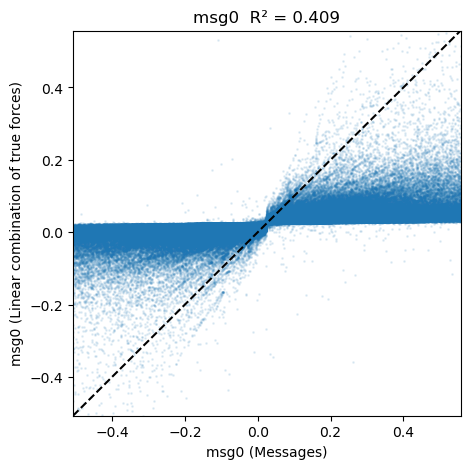

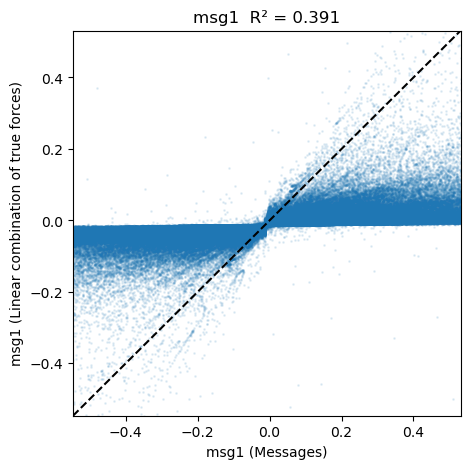

In [33]:
# Measure latent variables
latent_df_bottleneck = measure_latent(model_bottleneck, testloader, device=device, dim=dim, msg_dim=msg_dim_bottleneck)



# compute true force components and add them to latent_df
latent_df_bottleneck['fx_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dx'] / (latent_df_bottleneck['r'] ** 3 + 1e-6))
latent_df_bottleneck['fy_true'] = -(latent_df_bottleneck['m1'] * latent_df_bottleneck['m2']) * \
                    (latent_df_bottleneck['dy'] / (latent_df_bottleneck['r'] ** 3 + 1e-6))



# Fit multi-output linear regression to find top channels
lr, top_channels = fit_multioutput_force(latent_df_bottleneck, dim=dim)
print("Selected channels:", top_channels)

# Plot the true vs predicted values for the top channels
Forces = latent_df_bottleneck[['fx_true', 'fy_true']].values

# True messages
Messages = latent_df_bottleneck[top_channels].values

# Predicted message value using the linear regression model from the force
Predicted_messages = lr.predict(Forces)

for idx, ch in enumerate(top_channels):
    y_true_ch = Messages[:, idx]
    y_pred_ch = Predicted_messages[:, idx]

    combined = np.concatenate([y_true_ch, y_pred_ch])
    p_lower, p_upper = np.percentile(combined, [1, 99])

    plt.figure(figsize=(5, 5))
    plt.scatter(y_true_ch, y_pred_ch, s=1, alpha=0.1)
    plt.plot([p_lower, p_upper], [p_lower, p_upper], 'k--')
    plt.xlim(p_lower, p_upper)
    plt.ylim(p_lower, p_upper)
    plt.xlabel(f"{ch} (Messages)")
    plt.ylabel(f"{ch} (Linear combination of true forces)")
    

    single_r2 = r2_score(y_true_ch, y_pred_ch)
    plt.title(f"{ch}  R² = {single_r2:.3f}")
    plt.show()